<div style="text-align: left; font-family:Arial; padding: 12px; line-height:1.25;border-radius:1px; margin-bottom: 0em; text-align: center; font-size: 25px;">PLANT LEAF DISEASE DETECTION PROBLEM USING XGBOOST</div>

<div style="text-align: left; font-family:Arial; padding: 12px; line-height:1.25;border-radius:1px; margin-bottom: 0em; text-align: center; font-size: 25px;">SONG SONG HÓA MÔ HÌNH XGBOOST CHO BÀI TOÁN PHÁT HIỆN BỆNH LÁ CÂY</div>

#### Thành viên:
- Hồng Nhất Phương - 20120165
- Phạm Quốc Hưng - 19120522

**Kế hoạch và phân công công việc:** [Bảng phân công](https://docs.google.com/spreadsheets/d/1fUyQ2pJOh1ZJiij9-mTULY5PWI4_inJECpd3Jq3rO-Y/edit#gid=2048272829)

## 1. GIỚI THIỆU ĐỀ TÀI

Song song hóa mô hình học máy là một cách để tăng tốc quá trình huấn luyện, tiết kiệm thời gian và có thể triển khai mô hình trên các tập dữ liệu lớn hơn. Vì lý do đó, nhóm đã quyết định chọn đề tài song song hóa mô hình học máy, cụ thể là mô hình XGBoost được sử dụng cho bài toán phát hiện bệnh ở lá cây. 

Kế hoạch song song hóa của nhóm là viết lại thuật toán XGBoost mà không cần gọi thư viện của nó, sau đó song song hóa những đoạn code có thể song song và thực hiện tối ưu hóa để tăng hiệu suất. Để hoàn thành dự án này, nhóm đã sử dụng thư viện numpy, numba và môi trường google colab để chạy mô hình.

## 2. CÀI ĐẶT

Bài toán là quá trình dự đoán bệnh từ hình ảnh lá cây bằng thuật toán XGBoost và tận dụng các thuật toán song song và kĩ thuật cải tiến để tăng tốc quá trình. Bài toán bao gồm các giai đoạn sau:
- Thu thập dữ liệu
- Trích xuất đặc trưng
- Cài đặt mô hình XGBoost tuần tự, huấn luyện mô hình và dự đoán kết quả
- Song song hóa mô hình XGBoost, thực hiện tối ưu hóa, huấn luyện mô hình và dự đoán kết quả
- Tổng kết và so sánh kết quả

### 2.1 THU THẬP DỮ LIỆU

Bài toán sử dụng bộ dữ liệu **Tomato leaf leaf disease detection dataset** trên [Kaggle](https://www.kaggle.com/datasets/kaustubhb999/tomatoleaf?fbclid=IwAR3QVtWoGaimTXgPXEpXzz7jPiFVIkDnJ6XfHvld06-xw1DvJ8u-jGxky0A) chứa 10.000 mẫu huấn luyện và 1000 mẫu dự đoán. Bộ dữ liệu có 10 nhãn bao gồm 1 nhãn khỏe mạnh (healthy) và 9 nhãn bệnh: 
- Tomato_mosaic_virus
- Target_Spot
- Bacterial_spot
- Tomato_Yellow_Leaf_Curl_Virus
- Late_blight
- Leaf_Mold
- Early_blight
- Spider_mites Two-spotted_spider_mite
- Septoria_leaf_spot

**Toàn bộ dữ liệu được lưu trong folder [dataset](https://github.com/NhatPhuong2106/Applied_Parallel_Programming/tree/main/dataset), thông tin chi tiết về tập dữ liệu huấn luyện được ghi trong file [**understand_data.ipynb**](https://github.com/NhatPhuong2106/Applied_Parallel_Programming/blob/main/data_preprocessing/understand_data.ipynb)**


Hiển thị ngẫu nhiên một bức ảnh của từng class 

In [1]:
#Import thư viện
import matplotlib.pyplot as plt
import cv2
import os
import pandas as pd
import seaborn as sns

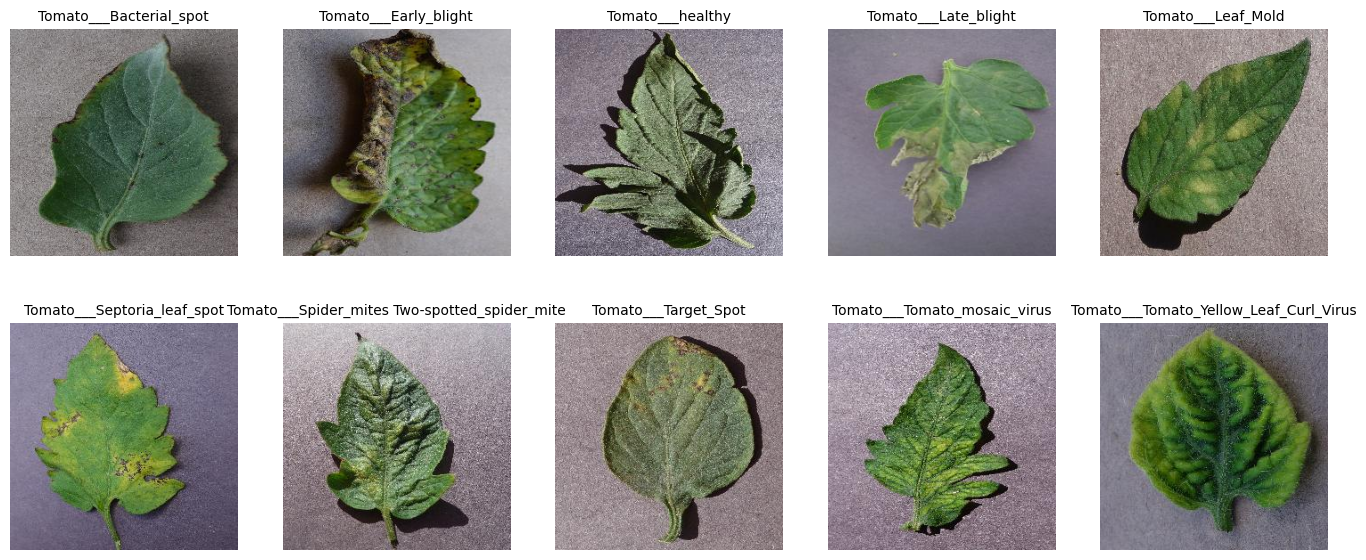

In [2]:
#Đọc ảnh
image_path = "../dataset/train"
labels = os.listdir(image_path)

#Hiển thị ảnh
plt.figure(figsize=(17, 7))
for i, disease in enumerate(labels):
    plt.subplot(2, 5, i + 1)
    list_image = os.listdir(image_path + '/' + disease)
    image = cv2.imread(os.path.join(os.path.join(image_path, disease), list_image[21]))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.title(disease, fontsize = 10)
    plt.axis("off")

### 2.2 RÚT TRÍCH ĐẶC TRƯNG

Rút trích đặc trưng tạo ra những đặc trưng tách lớp tốt cho việc phân lớp mẫu. Quá trình thực hiện rút trích đặc trưng sẽ trải qua những bước sau:

#### 2.2.1 Phân đoạn hình ảnh sử dụng Color Detection (Image segmentation using Color Detection)

Được sử dụng để tách hình ảnh chiếc lá khỏi nền. Hình ảnh chiếc lá được lấy ra khỏi nền bằng cách sử dụng ranh giới màu hsv, ranh giới màu sắc sẽ mở rộng thay vì giới hạn nghiêm ngặt để có thể quét được mọi trường hợp, cho ra hình ảnh chiếc lá được tách hoàn toàn khỏi nền.

Ảnh minh họa cho việc phân đoạn hình ảnh

<img src="picture/img_seg.jpg"  />

#### 2.2.2 Sử dụng các Global feature descriptors để tiến hành trích xuất đặc trưng

Global feature descriptors thường được sử dụng trong việc truy xuất hình ảnh, phát hiện và phân loại đối tượng. Các đặc trưng toàn cục (Global features) mô tả toàn bộ hình ảnh để khái quát hóa toàn bộ đối tượng, chúng bao gồm biểu diễn màu sắc, mô tả hình dạng và đặc trưng kết cấu,...

Trích xuất các đặc trưng trên 3 bộ mô tả tính năng toàn cục (global feature descriptors):
- Hình dạng: Hu Moments - được sử dụng để mô tả hình dạng của một đối tượng trong hình ảnh.
  
- Kết cấu: Haralick feature - được sử dụng để mô tả kết cấu của hình ảnh. Kết cấu đề cập đến hình thức, tính nhất quán hoặc “cảm giác” của bề mặt.
  
- Màu sắc: Color Histograms - đếm số lần cường độ điểm ảnh nhất định (hoặc phạm vi cường độ điểm ảnh) xuất hiện trong một hình ảnh. Bằng cách sử dụng biểu đồ màu, chúng ta có thể biểu thị sự phân bố thực tế hoặc “số lượng” của từng màu trong ảnh

Sau khi đã trích xuất, kết quả sẽ được nối lại để tạo thành một mảng duy nhất.

#### 2.2.3 Chuẩn hóa đặc trưng và lưu kết quả

- Chuẩn hóa đặc trưng (feature scaling) là một bước quan trọng trong quá trình tiền xử lý dữ liệu, nhằm chuyển các đặc trưng về cùng một thang đo chung, giúp cho việc biểu diễn dữ liệu dễ dàng và các mô hình phân tích nhất là các mô hình học máy hoạt động hiệu quả hơn. Sử dụng Min-Max Scaling để chuẩn hóa.

- Sử dụng thư viện numpy để lưu data X và nhãn y để dùng cho giai đoạn tiếp theo.

**Toàn bộ cách thực hiện chi tiết được ghi trong file [**feature_extract.ipynb**](https://github.com/NhatPhuong2106/Applied_Parallel_Programming/blob/main/data_preprocessing/feature_extract.ipynb)**

### 2.3 CÀI ĐẶT MÔ HÌNH TUẦN TỰ

#### 2.3.1 Tính toán pseudo residuals

$Residuals = y - p$  
* $y$: Nhãn thực tế
* $p$: Xác suất điểm dữ liệu thuộc về một nhãn nào đó mà mô hình dự đoán  

Xác suất dự đoán mặc định ban đầu thường là 0.5

#### 2.3.2 Tìm split tốt nhất

XGBoost sử dụng độ đo `Similarity Score` để chọn ra threshold tách nhánh trong quá trình xây dựng cây quyết định  

*Similarity Score* = $\frac{∑(Residuals)^2}{∑P*(1-P-1) + λ}$  

* $P$: Xác suất của lần dự đoán trước đó
* $λ$: Regularization parameter

Đặc trưng và giá trị có chỉ số `Gain` cao nhất sẽ được chọn làm threshold phân nhánh

$Gain = SimilarityScore(LeftChild) + SimilarityScore(RightChild) - SimilarityScore(Root)$

#### 2.3.3 Tính toán giá trị output 

Giá trị output được lưu trữ ở node lá, tính bằng công thức  

$Output = \frac{∑(Residuals)}{∑P*(1-P) + λ}$

#### 2.3.4 Cập nhật xác suất dự đoán

Giá trị xác suất dự đoán sẽ được cập nhật dựa trên giá trị output đã tính toán được  

$Prediction = ln(\frac{P}{1-P}) + α*Output$

* $P$: Xác suất của lần dự đoán trước đó
* $α$: Learning rate
* $Output$: Giá trị output của cây hiện tại

Kết quả tính được từ công thức trên thực chất là giá trị log odds. Vì vậy, cần phải qua một bước chuyển đổi sang giá trị xác suất  

$Probability = \frac{e^{pred}}{1 + e^{pred}}$  

* $pred$: Giá trị log odds

Cập nhật pseudo residuals với giá trị xác suất mới và lặp lại các bước trên cho những lần xây dựng cây sau

#### 2.3.5 Huấn luyện mô hình

- Bộ dữ liệu: do dữ liệu 10.000 mẫu ban đầu quá lớn làm cho việc chạy mô hình tuần tự trở nên rất lâu, vì thế trước tiên thử nghiệm trên bộ dữ liệu nhỏ 3.000 mẫu nhằm so sánh độ chính xác giữa các phiên bản
- Chiến lược phân lớp: sử dụng One vs Rest (OvR) phân loại đa lớp cho mô hình

Chi tiết phần cài đặt có thể xem trong [**xgboost_sequential.ipynb**](https://github.com/NhatPhuong2106/Applied_Parallel_Programming/blob/main/xgboost/xgboost_sequential.ipynb)

#### KẾT QUẢ 

In [30]:
result_df = pd.read_csv("../xgboost/result.csv")
result_df[['Labels', 'n_estimators', 'learning_rate', 'Sequential_training_time', 'Sequential_accuracy']].iloc[[0,1]]

,Labels,n_estimators,learning_rate,Sequential_training_time,Sequential_accuracy
0,binary_labels,3,0.3,357.048,0.947
1,three_labels,3,0.3,1062.156,0.957


**Nhận xét**: Mô hình tuần tự đã cài đặt thành công với độ chính xác khá tốt, hiện tại cần tiến hành song song hóa để giảm bớt thời gian thực thi, tăng hiệu suất

### 2.4 CÀI ĐẶT MÔ HÌNH SONG SONG

![Data](../report/picture/analysis.jpg)

Thực hiện song song hoá một số hàm có khả năng song song nhằm triển khai XGBoost với thời gian thực thi ngắn hơn so với phiên bản tuần tự ban đầu trong khi mô hình vẫn duy trì độ chính xác chấp nhận được

Bức ảnh trên ghi lại thời gian thực thi của những giai đoạn chính trong mô hình XGBoost tuần tự. Trong các giai đoạn này, ta thấy rằng phần **Xây dựng cây quyết định** hay cụ thể hơn là hàm `find_best_split()` chiếm hầu hết thời gian thực thi, do vậy mục tiêu chính là song song hoá thành công hàm `find_best_split()` vì đây là hàm chiếm hơn 90% tổng thời gian chạy XGBoost, nếu song song hoá tốt hàm này, thời gian thực thi tổng thể sẽ giảm đi rất nhiều. Ngoài ra, nhóm cũng sẽ tiến hành song song hoá một số hàm tính toán khác với mong muốn giảm thời gian huấn luyện đến mức thấp nhất.

#### 2.4.1 Song song hóa hàm `find_best_split()`

**Mô tả hàm**: `find_best_split()` là hàm tìm giá trị split sao cho gain của chúng khi rẽ nhánh đạt giá trị lớn nhất => đây là giá trị split tốt nhất dùng để rẽ nhánh.

**Ý tưởng song song**: Chia làm 2 hàm con:
- `compute_split_value()`: tính tất cả giá trị split value, mỗi thread sẽ đảm nhiệm tính một giá trị split
- `compute_gain()`: sau khi xác định được mảng giá trị split, với mỗi giá trị, ta tiến hành rẽ nhánh và tính gain.
  
Kết hợp với `np.argmax()` của thư viện numpy để tìm được giá trị split tốt nhất. Tương tự như ý tưởng tuần tự, ta lưu vị trí feature cùng với giá trị split và best_gain.

#### 2.4.2 Song song hóa hàm `residual()`

**Mô tả hàm**: `residual()` là hàm tính toán sự chênh lệch giữa y thực tế và kết quả dự đoán

**Ý tưởng song song**: Mỗi một thread sẽ được dùng để tính giá trị residual của một mẫu (sample)

#### 2.4.3 Song song hóa hàm `compute_logodds()`

**Mô tả hàm**: `compute_logodds()` là hàm chuyển giá trị xác suất p thành giá trị log(odds)

**Ý tưởng song song**: Mỗi một thread sẽ được dùng để tính giá trị log(odds) của một mẫu (sample)

#### 2.4.4 Song song hóa hàm `compute_prob()`

**Mô tả hàm**: `compute_prob()` là hàm chuyển giá trị log(odds) thành giá trị xác suất p   

**Ý tưởng song song**: Mỗi một thread sẽ được dùng để tính giá trị xác suất p của một mẫu (sample)

#### 2.4.5 Huấn luyện mô hình

- Bộ dữ liệu: 
  - Do dữ liệu 10.000 mẫu ban đầu quá lớn làm cho việc chạy mô hình tuần tự trở nên rất lâu, vì thế trước tiên thử nghiệm trên bộ dữ liệu nhỏ 3.000 mẫu nhằm so sánh độ chính xác giữa các phiên bản
  - Tại phiên bản này, bên cạnh bộ dữ liệu nhỏ, nhóm tiếp tục huấn luyện trên bộ dữ liệu 10.000 mẫu để so sánh phiên bản song song và cải tiến
- Chiến lược phân lớp: sử dụng One vs Rest (OvR) phân loại đa lớp cho mô hình

Chi tiết phần cài đặt có thể xem trong [**xgboost_parallel.ipynb**](https://github.com/NhatPhuong2106/Applied_Parallel_Programming/blob/main/xgboost/xgboost_parallel.ipynb)

#### KẾT QUẢ

Độ chính xác và thời gian chạy của 2 phiên bản tuần tự và song song được thể hiện bằng biểu đồ bên dưới. 

In [19]:
result_df = pd.read_csv("../xgboost/result.csv")

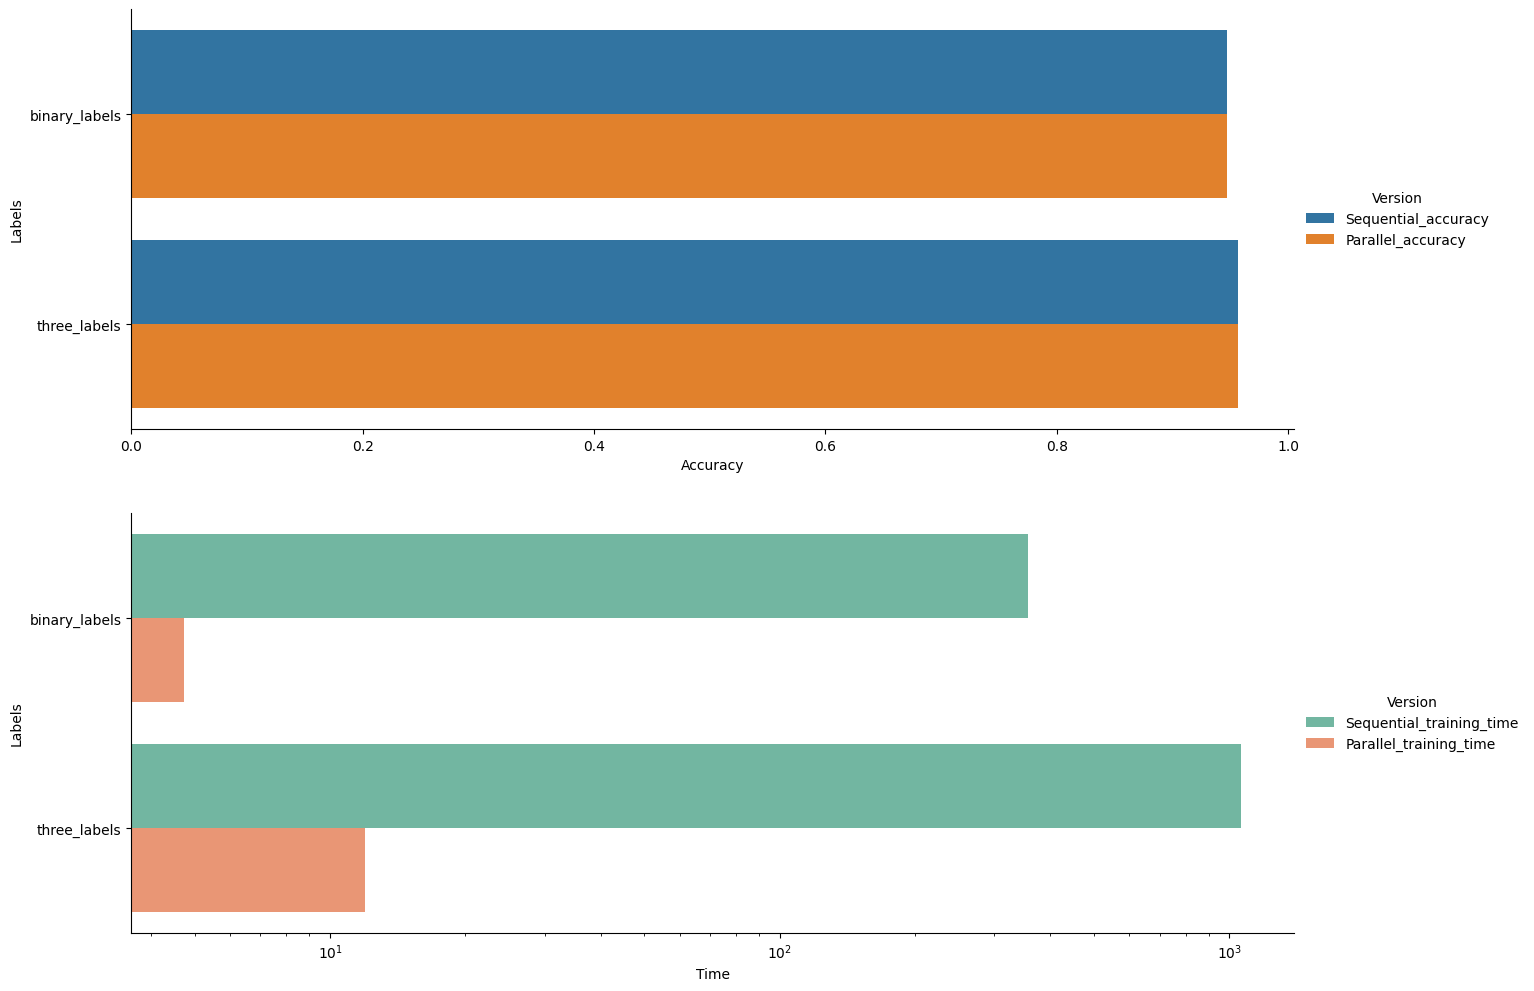

In [36]:
acc_df = result_df[['Labels', 'Sequential_accuracy', 'Parallel_accuracy']].iloc[[0, 1]]
acc_df = pd.melt(acc_df, id_vars = 'Labels', var_name = 'Version', value_name= 'Accuracy')

time_df = result_df[['Labels', 'Sequential_training_time', 'Parallel_training_time']].iloc[[0, 1]]
time_df = pd.melt(time_df, id_vars = 'Labels', var_name = 'Version', value_name= 'Time')

plt.figure(figsize=(15, 12))
plt.subplot(2, 1, 1)
ax = sns.barplot(x = 'Accuracy', y = 'Labels', hue = 'Version', data = acc_df)
ax.spines[['top', 'right']].set_visible(False)
sns.move_legend(ax, bbox_to_anchor = (1, 0.5), loc = 'center left', frameon = False)

plt.subplot(2, 1, 2)
plt.xscale('log')
ax = sns.barplot(x = 'Time', y = 'Labels', hue = 'Version', data = time_df, palette = sns.color_palette("Set2"))
ax.spines[['top', 'right']].set_visible(False)
sns.move_legend(ax, bbox_to_anchor = (1, 0.5), loc = 'center left', frameon = False)


**Nhận xét**: Phiên bản song song đã cải thiện tốt thời gian huấn luyện và vẫn đảm bảo được độ chính xác.

### 2.5 CÀI ĐẶT MÔ HÌNH OPTIMIZE

Áp dụng một số cải tiến giúp cải thiện hiệu suất mô hình, giảm số lần truy cập bộ nhớ, giảm thời gian thực thi nhưng vẫn đảm bảo được độ chính xác của mô hình

#### 2.5.1 Áp dụng kĩ thuật cải tiến cho hàm `compute_split_value()`

Tạo hàm `compute_split_value_optimize()` áp dụng các kĩ thuật cải tiến lên hàm song song hóa ban đầu

- Cải tiến 1: Trong quá trình transfer dữ liệu từ CPU/Host sang GPU/Device, Numba mặc định sẽ tự động copy dữ liệu của các tham số truyền vào hàm kernel từ Host sang Device, sau khi chạy xong hàm kernel thì sẽ copy các tham số truyền vào trước đó ngược lại về Host. Để tối ưu, ta chỉ cần copy dữ liệu cần thiết và bỏ qua dữ liệu không cần thiết khi transfer dữ liệu từ Host sang Device và Device về lại Host.
  
- Cải tiến 2: Dữ liệu của sample X nằm ở bộ nhớ GMEM, và mỗi lần đọc dữ liệu của X thì các thread đều phải chạy xuống GMEM. Vì vậy sử dụng SMEM chứa phần dữ liệu mong muốn để tính split_value. Giả sử kích thước block là 4 x 4, thì kích thước share là 5 x 4 (vì 1 $split\_value$ element cần 2 $x$ elements). Các thread sẽ lấy phần dữ liệu ứng với chỉ số `(row, col)` của chúng và ghi vào SMEM, đối với phần dữ liệu còn lại sẽ do thread liền trước đó xử lý

#### 2.5.2 Áp dụng kĩ thuật cải tiến cho hàm `compute_gain()`

Tạo hàm `compute_gain_optimize()` áp dụng các kĩ thuật cải tiến lên hàm song song hóa ban đầu

- Cải tiến 1: Tương tự với cải tiến 1 của hàm `compute_split_value_optimize()`, ta chỉ cần copy dữ liệu cần thiết khi transfer dữ liệu từ Host sang Device và chỉ lấy ra kết quả là dãy giá trị gain tính được từ Device về Host memory
  
- Cải tiến 2: Dữ liệu của X, residual, prob và root gain đều nằm ở bộ nhớ GMEM, mỗi lần đọc dữ liệu thì các thread đều phải chạy xuống GMEM. Do vậy sử dụng SMEM load phần dữ liệu X, residual, prob, root gain mong muốn, phục vụ cho việc so sánh giá trị và tính gain. Với root gain, ta sẽ để thread có chỉ số `(tx = 0, ty = 0)` load dữ liệu vào SMEM. Với các dữ liệu còn lại, ta sẽ chia phần dữ liệu mà block cần thành nhiều phần nhỏ. Ở lần xử lý đầu tiên, block sẽ load một phần nhỏ của dữ liệu từ GMEM vào SMEM, rồi mỗi thread trong block đọc dữ liệu ở SMEM để tính một phần kết quả; ở lần xử lý kế, block sẽ load phần nhỏ tiếp theo (ghi đè lên dữ liệu cũ) và tính tiếp từ kết quả đang tính trước đó, tiếp tục cho đến hết.

#### 2.5.3 Áp dụng kĩ thuật cải tiến cho các hàm `residual_optimize()`, `compute_logodds_optimize()`, `compute_prob_optimize()`

Các hàm `residual_optimize()` , `compute_logodds_optimize()`, `compute_prob_optimize()` sẽ cho mỗi thread block xử lý $2 * blockDim.x$ phần tử. Tất cả các thread trong mỗi block sẽ xử lý $blockDim.x$ phần tử đầu mảng, mỗi thread xử lý một phần tử, sau đó tất cả các thread sẽ chuyển sang $blockDim.x$ phần tử sau của mảng, mỗi thread xử lý một phần tử. Tương tự với các hàm tối ưu trước, chỉ copy dữ liệu cần thiết khi transfer dữ liệu từ Host sang Device và copy mảng kết quả về Host memory

#### 2.5.4 Huấn luyện mô hình

- Bộ dữ liệu: 
  - Do dữ liệu 10.000 mẫu ban đầu quá lớn làm cho việc chạy mô hình tuần tự trở nên rất lâu, vì thế trước tiên thử nghiệm trên bộ dữ liệu nhỏ 3.000 mẫu nhằm so sánh độ chính xác giữa các phiên bản
  - Tại phiên bản này, bên cạnh bộ dữ liệu nhỏ, nhóm tiếp tục huấn luyện trên bộ dữ liệu 10.000 mẫu để so sánh phiên bản song song và cải tiến
- Chiến lược phân lớp: sử dụng One vs Rest (OvR) phân loại đa lớp cho mô hình

Chi tiết phần cài đặt có thể xem trong [**xgboost_optimize.ipynb**](https://github.com/NhatPhuong2106/Applied_Parallel_Programming/blob/main/xgboost/xgboost_optimize.ipynb)

#### KẾT QUẢ

Độ chính xác và thời gian chạy của 3 phiên bản tuần tự, song song và optimize được thể hiện bằng biểu đồ bên dưới. 

In [37]:
result_df = pd.read_csv("../xgboost/result.csv")

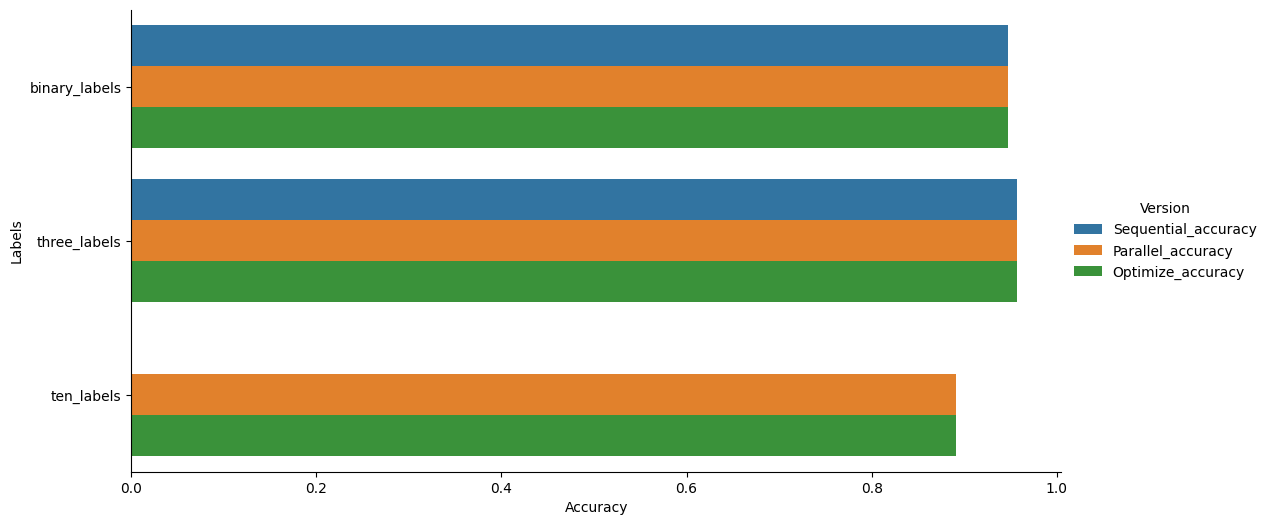

In [11]:
acc_df = result_df[['Labels', 'Sequential_accuracy', 'Parallel_accuracy', 'Optimize_accuracy']]
acc_df = pd.melt(acc_df, id_vars = 'Labels', var_name = 'Version', value_name= 'Accuracy')

plt.figure(figsize=(12, 6))
ax = sns.barplot(x = 'Accuracy', y = 'Labels', hue = 'Version', data = acc_df)
ax.spines[['top', 'right']].set_visible(False)
sns.move_legend(ax, bbox_to_anchor = (1, 0.5), loc = 'center left', frameon = False)

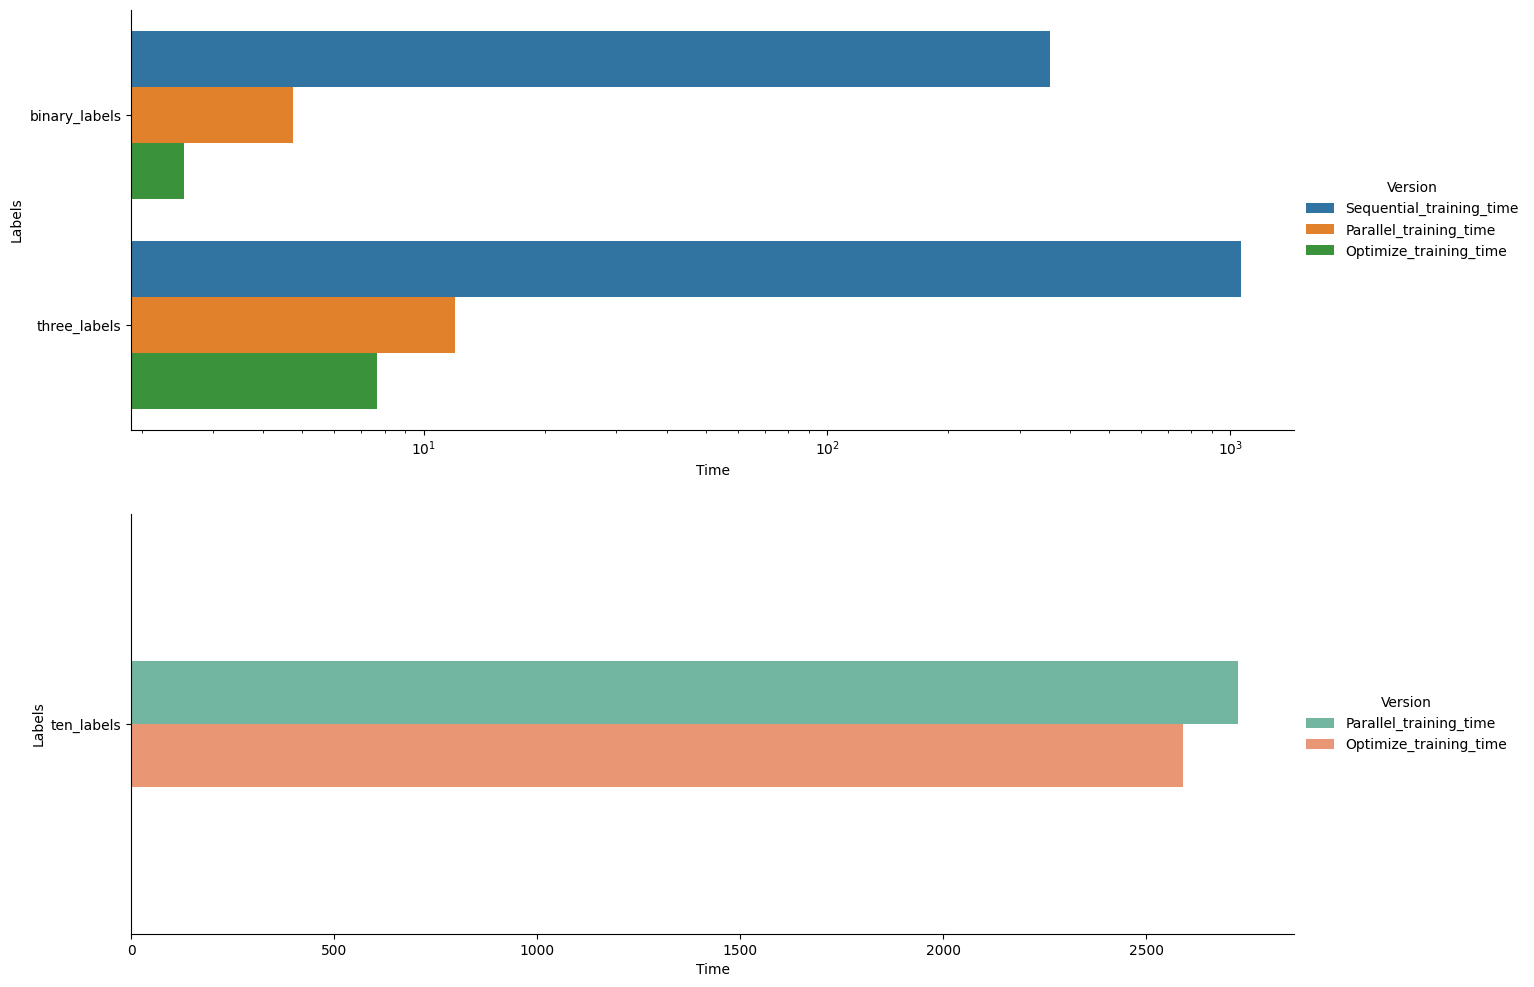

In [43]:
time_df = result_df[['Labels', 'Sequential_training_time', 'Parallel_training_time', 'Optimize_training_time']].iloc[[0, 1]]
time_df = pd.melt(time_df, id_vars = 'Labels', var_name = 'Version', value_name= 'Time')

df = result_df.drop(result_df.index[[0, 1]])
time_df2 = df[['Labels', 'Parallel_training_time', 'Optimize_training_time']]
time_df2 = pd.melt(time_df2, id_vars = 'Labels', var_name = 'Version', value_name= 'Time')

plt.figure(figsize=(15, 12))
plt.subplot(2, 1, 1)
ax = sns.barplot(x = 'Time', y = 'Labels', hue = 'Version', data = time_df)
plt.xscale('log')
ax.spines[['top', 'right']].set_visible(False)
sns.move_legend(ax, bbox_to_anchor = (1, 0.5), loc = 'center left', frameon = False)

plt.subplot(2, 1, 2)
ax = sns.barplot(x = 'Time', y = 'Labels', hue = 'Version', data = time_df2, width = 0.3, palette = sns.color_palette("Set2"))
ax.spines[['top', 'right']].set_visible(False)
sns.move_legend(ax, bbox_to_anchor = (1, 0.5), loc = 'center left', frameon = False)

**Nhận xét:** Phiên bản optimize đã cải thiện tốt thời gian huấn luyện và vẫn đảm bảo được độ chính xác trong mọi bộ dữ liệu